# A convolutional MNIST classifier in PyTorch
Sam Greydanus | 2018 | MIT License

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os, copy, time, pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils

# set up the workspace
reseed = lambda: np.random.seed(seed=0) ; ms = torch.manual_seed(0) # for reproducibility
reseed()

os.mkdir('figures') if not os.path.exists('figures') else None
os.mkdir('saved') if not os.path.exists('saved') else None

## Data loader
<img src="static/mnist.png" alt="MNIST training samples" style="width: 200px;"/>

In the code below, I essentially wrap the PyTorch MNIST utility. A few examples from the MNIST dataset are shown above.

Now we can access either the train or test sets, depending on the mode we request. I also include a utility for converting labels to one-hot labels and a utility for measuring the accuracy of a classifier.

In [2]:
class MnistLoader():
    def __init__(self):
        self.modes = modes = ['train', 'test']
        trans = transforms.Compose([transforms.ToTensor(),]) # transforms.Normalize((0.1307,), (0.3081,))
        self.dsets = {k: datasets.MNIST('./data', train=k=='train', download=True, transform=trans) for k in modes}
        self.loaders = {m: iter([]) for m in modes}
        self.batch_size = None

    def next(self, batch_size, mode='train', sigma=0):
        if batch_size is not None and batch_size != self.batch_size:
            self.loaders[mode] = iter(torch.utils.data.DataLoader(self.dsets[mode], batch_size, shuffle=True))
            self.batch_size = batch_size
        data = next(self.loaders[mode], None)
        if data is None or batch_size != data[0].shape[0]:
            self.loaders[mode] = iter(torch.utils.data.DataLoader(self.dsets[mode], batch_size, shuffle=True))
            data = next(self.loaders[mode], None)
        return data[0].view(self.batch_size, 28**2).numpy(), data[1].numpy()
    
def onehot(values, n_values): # converts to one-hot (use np.argmax to convert back)
    oh = np.zeros((values.size, n_values))
    oh[range(values.size), values.ravel()] = 1
    return oh.reshape(list(values.shape) + [10])

def accuracy(model, dataloader, samples=10000, mode='test'):
    X, y = dataloader.next(samples, mode=mode)
    model.eval()      # put model in evaluation mode
    logits = model.forward(X) # logits should be a numpy array
    model.train()     # put model in train mode
    y = onehot(y, logits.shape[-1])
    return 100*sum(y.argmax(1) == logits.argmax(1))/samples # assumes y and y_hat are numpy arrays

## Model

This is a three-layer, fully-connected classifier with ReLU activations. It's pretty easy in PyTorch.

In [3]:
# small conv classifier (has 9466 parameters)
class ConvMnistClassifier(nn.Module):
    def __init__(self, channels=12):
        super(ConvMnistClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, stride=1, padding=0) # batch channels (24 24) -> (12 12) w maxpool
        self.conv2 = nn.Conv2d(10, 20, 5, stride=1, padding=0) # batch channels (8 8) -> (4 4) w maxpool
        self.linear = nn.Linear((4**2)*20, 10) # 4^2 * channels ->10

    def forward(self, x):
        x = Variable(torch.Tensor(x)) if type(x) == np.ndarray else x # maybe convert to an autograd variable
        x = x.contiguous().view(-1,1,28,28)
        batch = x.shape[0]
        
        h1 = F.relu(F.max_pool2d(self.conv1(x), 2))
        h2 = F.relu(F.max_pool2d(self.conv2(h1), 2))
        h2_flat = h2.view(batch, -1) # flatten the conv features
        logits = self.linear(h2_flat) # a linear classifier goes on top
        
        return logits if self.training else logits.data.numpy() # maybe return as a numpy array, else as a Variable

## Utility functions
For loading, saving, keeping a running mean of the loss

In [4]:
def to_pickle(thing, name): # save something
    with open('saved/{}.pkl'.format(name), 'wb') as handle:
        pickle.dump(thing, handle, protocol=pickle.HIGHEST_PROTOCOL)

def from_pickle(name): # load something
    thing = None
    with open('saved/{}.pkl'.format(name), 'rb') as handle:
        thing = pickle.load(handle)
    return thing

running_mean = lambda mean, update: update if mean is None else .99*mean + (1-.99)*update

## Hyperparameters
We'll use a trick to make our dictionary of hyperparameters and other training info look like an object. I'm doing this out of personal taste. Reasons to do it this way:

* Dictionaries are a fundamental Python data structure
 * everyone knows how to interact with dictionaries
 * this makes my work (maybe) easier to follow?
* Dictionaries are easy to save/load compared to objects
 * so loading a saved model plus its training metadata is easy
* Objects are easier to interact with
 * `info.global_step` is cleaner than `info['global_step']`
 * yes, I'm a bit of a perfectionist
    
By making a dictionary that looks like an object, we get the best of both worlds :)

In [5]:
info_dict = {'hidden_dim': 200,
        'lr': 1e-2,
        'batch_size': 128,
        'test_every': 100,
        'global_step': 0,
        'epochs': 3,
        'loss': [],
        'accuracy': [],
        'name': 'mnist-cnn'}
info_dict['total_steps'] = int(info_dict['epochs']*60000/info_dict['batch_size'])

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
info = ObjectView(info_dict)

## Initialize everything

In this case, we just make a dataloader and a model. The optimizer is just SGD.

In [6]:
dataloader = MnistLoader()
model = ConvMnistClassifier(info.hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=info.lr)
model.train() # put model in train mode

try:
    [model, info_dict] = from_pickle(info.name)
    info = ObjectView(info_dict)
    print('\t* loaded a model')
except:
    print('\t* no model to load')
    
acc = accuracy(model, dataloader, mode='test')
print('test accuracy: {:.2f}%'.format(acc))

	* loaded a model
test accuracy: 98.69%


## Train

We define $\mathcal{L}$ to be the negative log likelihood objective and solve:
$$ \operatorname*{arg\,min}_\theta \mathcal{L} \quad \textrm{where} \quad \mathcal{L} = \frac{1}{N}\sum^N -y_k \log(\hat y_k) $$
In the equation above, $N$ is the minibatch size, $y$ is the supervised training label and $\hat y$ is the softmax distribution of the classifier. Also, $k$ is the index where the one-hot vector $y_k$ is equal to 1 (it is class label).

In [7]:
start_t = print_t = time.time()
run_loss = None
test_acc = train_acc = 10
for step in range(info.global_step+1, info.total_steps):
    
    X, y = dataloader.next(info.batch_size)  # get a minibatch
    logits = model(X)                        # forward pass
    y_hat = F.log_softmax(logits, dim=-1)    # log softmax over logits
    loss = F.nll_loss(y_hat, Variable(torch.LongTensor(y)))    # this is the loss function
    loss.backward() ; optimizer.step() ; optimizer.zero_grad() # get grads, apply with optimizer
    
    info.loss += [loss.data.view(-1)[0]]
    run_loss = running_mean(run_loss, loss.data.view(-1)[0])
    info.global_step = step
    if time.time() - print_t > .2:
        print_t = time.time()
        print('\tstep {}/{} | elapsed {:.1f}s | loss {:.4f} | test_acc {:.2f}% | train_acc {:.2f}%'
              .format(step, info.total_steps, time.time()-start_t, run_loss, test_acc, train_acc), end='\r')
    if step % info.test_every == 0 or step == info.total_steps-1:
        test_acc = accuracy(model, dataloader, samples=10000, mode='test')
        train_acc = accuracy(model, dataloader, samples=10000, mode='train')
        info.accuracy += [[test_acc, train_acc].copy()]
        
        to_pickle([model, info_dict], info.name) # save model and train stats

## Visualize examples

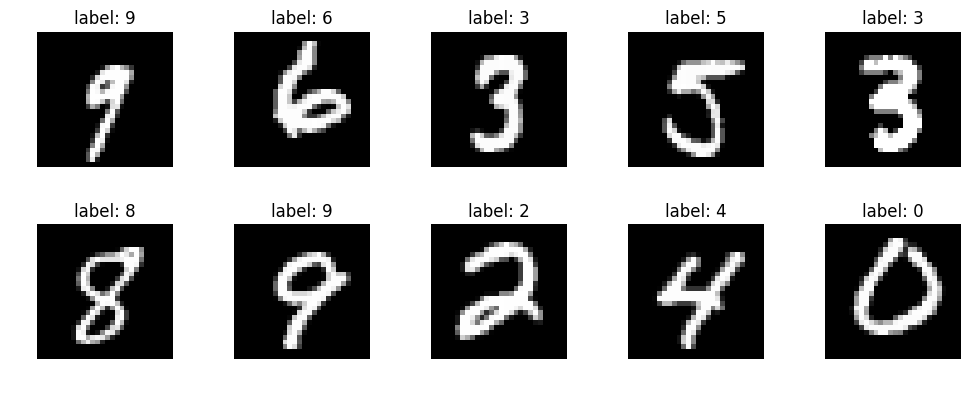

In [8]:
r, c = 2, 5
side = 2
f = plt.figure(figsize=[c*side, r*side], dpi=100)

X, y = dataloader.next(r*c, mode='test')
model.eval()
logits = model.forward(X)
labels = logits.argmax(1)

for j in range(r):
    for i in range(c):
        ix = j*c + i
        plt.subplot(r,c,ix+1)
        img = X[ix].reshape(28,28)
        plt.imshow(img, cmap='gray')
        plt.title('label: {}'.format(labels[ix]))
[a.axis('off') for a in f.get_axes()]
plt.tight_layout() ; plt.show()
f.savefig('figures/{}-example.png'.format(info_dict['name']))

## Visualize train stats

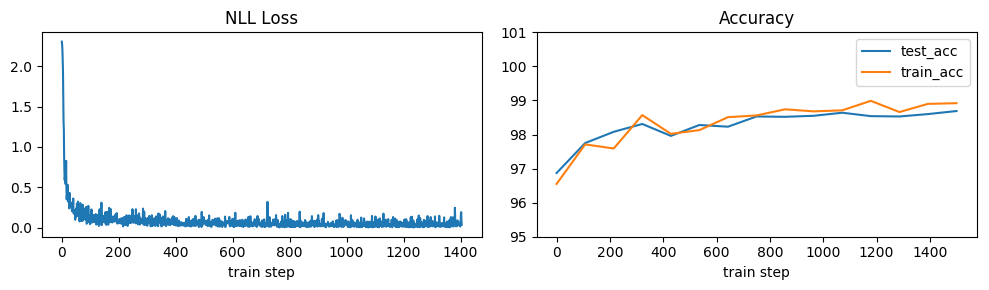

In [9]:
f = plt.figure(figsize=[10,3], dpi=100)
plt.subplot(1,2,1)
plt.plot(info_dict['loss'], label=info_dict['name'])
plt.title('NLL Loss') ; plt.xlabel('train step')

plt.subplot(1,2,2)
test_acc, train_acc = np.stack(info_dict['accuracy']).T
train_step_list = np.linspace(0,info_dict['test_every']*len(test_acc), len(test_acc))
plt.plot(train_step_list, test_acc, label='test_acc')
plt.plot(train_step_list, train_acc, label='train_acc')
plt.title('Accuracy') ; plt.xlabel('train step')
plt.ylim(95,101)

plt.legend()
plt.tight_layout() ; plt.show()
f.savefig('figures/{}-stats.png'.format(info_dict['name']))